In [2]:
import os
import numpy as np
import pandas as pd

import warnings 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as image
import matplotlib.patheffects as pe 
# from matplotlib import transforms

from nilearn import plotting, datasets
import nibabel as nb

In [3]:
# General settings
fs_title=20
fs_labels=15
fs_domainlabs=16 

fs_info=15 # in scheme of GWC

## Figure 1

In [3]:
# Read metadata
pre_time, pos_time = pd.read_excel('../fig1/ELS_timesheet.xlsx', sheet_name=['Prenatal', 'Postnatal']).values()

# Preprocess
def preprocess(d): 
    with pd.option_context('mode.chained_assignment', None): # avoind SettingWithCopyWarning
        d = d.loc[d.cohort=='R',] # Only Generation R
        d['item_name'] = [i.replace("_", " ") for i in d.item]
        d.fillna(0, inplace=True)
        d.set_index(d.item_name, inplace=True)
    return d
    
pre_time = preprocess(pre_time)
pos_time = preprocess(pos_time)

In [4]:
# Sub-plottling functions 
def stress_time(ax, t, title='Prenatal stress', color='#3300CC'):

    # Title --------------------------------------
    ax.set_title(title, fontsize = fs_title, fontweight = 'bold', pad=10)
    
    # Adjust axes ----------------------------------
    ylim = [-0.5, 52-.5]  # t.drop_duplicates('item').shape[0]
    xlim = [-27.5, 40] if title == 'Prenatal stress' else [-0.52, 10]
    
    ax.set(xlim=xlim, ylim=ylim)

    # DOMAINS -----------------------------------
    # domain_names = ['LIFE EVENTS','CONTEXTUAL RISK','PARENTAL RISK','INTERPERSONAL RISK','DIRECT VICTIMIZATION']
    domain_colors = ['y','r','b','g','darkviolet']
    domain_cuts = [-1] + [x - 1 for x in list(np.cumsum(t.drop_duplicates('item').domain.value_counts()[t.domain.unique()]))]
    
    # background color
    for c in range(len(domain_cuts)-1):
        buff = .4 if c != len(domain_cuts)-2 else 1.4
        ax.axhspan(domain_cuts[c]+.5, domain_cuts[c+1]+buff, facecolor=domain_colors[c], alpha=0.08)

    # RETROSPECTIVE SHADOWS ----------------------
    for it in t.item_name.unique():
        
        if type(t.loc[it, 'retros']) == np.float64:
            
            ax.fill_betweenx(y = it, x1 = t.loc[it, 'retros'], x2 = t.loc[it, 'meas'], color = 'grey', lw = 9, alpha = 0.2)
            if title=='Prenatal stress':
                ax.fill_betweenx(y = it, x1 = t.loc[it, 'from'], x2 = t.loc[it, 'to'], color = color, lw = 9.9, alpha = 1)
        else:
            for m, tm in enumerate(t.loc[it, 'retros']):
                ax.fill_betweenx(y = it, x1 = tm, x2 = t.loc[it, 'meas'][m], color = 'grey', lw = 9, alpha = 0.2)
                
    # TIME GRID -----------------------------------
    ax.axvline(x = 0, color = 'black', linewidth = 0.6)
    
    time_grid = [13.3,26.6] if title == 'Prenatal stress' else range(1,10)
    
    for i in time_grid:
        ax.axvline(x = i, color = 'grey', linewidth = 0.6, dashes = [10,2]) 

    # MAIN SCATTERPLOT -----------------------------
    t.plot(kind='scatter', x='meas', y='item_name', marker = "|", s = 100, ax = ax, color=color, linewidth=3, fontsize=15)

    # ----------- X-axis
    xlabel = 'Time (weeks gestation)' if title == 'Prenatal stress' else 'Time (child age in years)'
    ax.set_xlabel(xlabel, fontsize = fs_labels, fontweight = 'bold')
    
    xticks = range(0, 40+1, 20) if title == 'Prenatal stress' else range(0, 10+1)
    xticklabels = ['0','20',' Birth'] if title == 'Prenatal stress' else ['Birth']+[str(i) for i in range(1,10+1)]
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, fontsize = fs_labels)
    
    # ----------- Y-axis
    ax.set_ylabel('')
    
    yticklabels = list(t.item_name.unique())
    
    ax.set_yticks(range(0,len(yticklabels)))
    ax.set_yticklabels(yticklabels, fontsize = fs_labels)  # fontweight = 'bold'

    ax.tick_params(axis='y', direction='in', width=1, length=8)        

    ax.invert_yaxis()
    
    if title == 'Postnatal stress':
        ax.yaxis.tick_right() # Move items to the right

def add_legend(ax):
    ax.set(xlim=(0,1), ylim=(0,22))
    ax.invert_yaxis()
    
    domain_names = ['LIFE EVENTS','CONTEXTUAL RISK','PARENTAL RISK','INTERPERSONAL RISK','DIRECT VICTIMIZATION']
    domain_colors = ['y','r','b','g','darkviolet']
    
    for n, d in enumerate(domain_names):
        x = 0.04
        y = n + 0.5
        if n > 2: # two rows
            x = 0.5
            y = y-3
        
        ax.plot([x], [y], 's', ms=30, color=domain_colors[n], alpha=0.1)
        ax.text(x=x+.04, y=y, s=d, va='center', ha='left', fontsize=fs_domainlabs) # fontweight='bold'
        
    ax.axis('off')

def add_timeline(ax, color='#3300CC'):
    ax.arrow(-3, 0, 23, 0, width=4, head_width=5, head_length=.5, color=color, edgecolor=None)
    ax.set(xlim=(-3,26), ylim=(-7,7))
    breakln = dict(color='black', lw=1.5)
    x1, x2 = [-1,-.5], [-.8,-.3]
    ys=[-2.3,2.3]
    ax.plot(x1, ys, **breakln)
    ax.plot(x2, ys, **breakln)
    ax.fill_betweenx(y=ys, x1=x1, x2=x2, color='white', linewidth=0)
    for loc in [-1.3, 4.2, 6.8]:
        ax.text(loc, 4, s='...', fontsize=30, fontweight='bold')
        
    ax.text(-1.2, -4, s='Pregnancy', fontsize=15, ha='right')
    ax.text(-0.1, -4, s='Birth', fontsize=15)
    ax.text( 9.2, -4, s='10 years', fontsize=15)
    ax.axis('off') 

def add_image(fig, x, y, size, img_path, hcrop=0):
    img = image.imread(img_path)
    width = height = size # assume square for now
    
    # Define the position on the figure
    ax_image = fig1.add_axes([x, y, width, height])

    if hcrop > 0:
        img = img[hcrop:(img.shape[0]-2*hcrop),:,:]
        
    # Display the image
    ax_image.imshow(img)
    ax_image.axis('off')  # Remove axis of the image

def add_poligon(fig, p1, p2_top, p2_bot, widths=[1,1], style_lines='-', color='crimson'):
    # polygon
    pg = mpl.patches.Polygon(p1, fc='none', ec=color, lw=widths[0])
    fig.add_artist(pg)
    # lines
    dashes = (10,3) if style_lines == '--' else (None, None)
    
    for (x, y) in [zip(p1[0], p2_top), zip(p1[2], p2_bot)]:
        l = mpl.lines.Line2D(x, y, color=color, lw=widths[1], dashes=dashes) # length of 8, space of 2
        fig.add_artist(l)    

def add_scheme(fig, position):
    
    ax = fig.add_axes(position)
    xlim, ylim = (0,1.1), (-3,3)
    ax.set(xlim=xlim, ylim=ylim)

    bound_color = '#3300CC'
    gm_color, wm_color = '#333333','#FFFFFF'
    
    # Background
    ax.fill_between(x=[0,1], y1= 3, y2=0, color='#777777') # dark grey
    ax.fill_between(x=[0,1], y1=-3, y2=0, color='#A9A9A9') # light grey

    # Horizontal lines
    xlims = dict(xmin=0, xmax=1)
    pials = ax.hlines(y = 3, color='black',  lw=16, **xlims)  # Pial surface
    bound = ax.hlines(y = 0, color=bound_color,lw=8,  **xlims)  # boundary
    
    gm = ax.axhline(y = 1,  xmin=0, xmax=10/11, color=gm_color, lw=2, dashes=(10,3)) # **xlims, ls='dashed') # GM
    wm = ax.axhline(y =-1.5,xmin=0, xmax=10/11, color=wm_color, lw=2, dashes=(10,3)) # **xlims, ls='dashed') # WM
    
    # Arrows
    arrow_args = dict(arrowstyle='<->', mutation_scale=20)
    # whole cortical thickness
    ax.add_artist(mpl.patches.FancyArrowPatch(posA=(1.04,0), posB=(1.04, 3), color=bound_color, **arrow_args)) 
    # GM and WM
    ax.add_artist(mpl.patches.FancyArrowPatch(posA=(.55, 0), posB=(.55,0.96), color=gm_color, **arrow_args))
    ax.add_artist(mpl.patches.FancyArrowPatch(posA=(.55,-0.02), posB=(.55,-1.46),color=wm_color, **arrow_args))

    # Dots
    ax.scatter([.55,.55], [1,-1.5], s=100, facecolors='none', color='crimson', zorder=10)
    
    # text
    ax.text(x=-0.02, y=0, s='Grey/white\nmatter\nboundary', va='center', ha='right', fontsize=fs_info, color=bound_color)
    ax.text(x=0.99, y=3.1, s='Pial surface', va='bottom', ha='right', fontsize=fs_info) 
    ax.text(x=1.07, y=3.0, s='100%', va='top', ha='left', fontsize=fs_info, color=bound_color) 
    ax.text(x=1.07, y=1.5, s='Cortical\nthickness', va='center', ha='left', fontsize=fs_info, color=bound_color) 
    ax.text(x=1.07, y=0.0, s='0%', va='bottom', ha='left', fontsize=fs_info, color=bound_color) 

    gwmannot = dict(ha='left', fontsize=fs_info, color='crimson', path_effects=[pe.withStroke(linewidth=.2, foreground=gm_color)])
    ax.text(x=0.56, y=1.20, s=r'$i_{GM}$', va='bottom', **gwmannot)
    ax.text(x=0.56, y=-1.7, s=r'$i_{WM}$', va='top', **gwmannot)
    
    gwmtext = dict(va='center', ha='left', fontsize=fs_info, fontweight='bold')
    ax.text(x=0.05, y=2.35, s='Grey matter', color=gm_color, **gwmtext)
    ax.text(x=0.05, y=-2.4,s='White matter', color=wm_color, **gwmtext)
    
    gwmdist = dict(va='center', ha='right', fontsize=fs_info, fontweight='bold', bbox=dict(facecolor='white', edgecolor='white', alpha=0.2, pad=7))
    ax.text(x=0.45, y=0.50, s='30%', color=gm_color, **gwmdist)
    ax.text(x=0.45, y=-0.75, s='= 1 mm', color=wm_color, **gwmdist)

    # Equation 
    ax.text(x=0, y=4, s=r'GWC (%) = $\left[ \frac{i_{GM} - i_{WM}}{ (i_{GM} + i_{WM}) / 2} \right] * 100$', ha='left', fontsize=fs_title, 
            color='crimson', path_effects=[pe.withStroke(linewidth=.2, foreground=gm_color)])
    
    ax.axis('off')

/var/folders/f9/fknlq25n23l74zmhg8zbckx80000gn/T/ipykernel_9734/389120587.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.fill_betweenx(y = it, x1 = tm, x2 = t.loc[it, 'meas'][m], color = 'grey', lw = 9, alpha = 0.2)


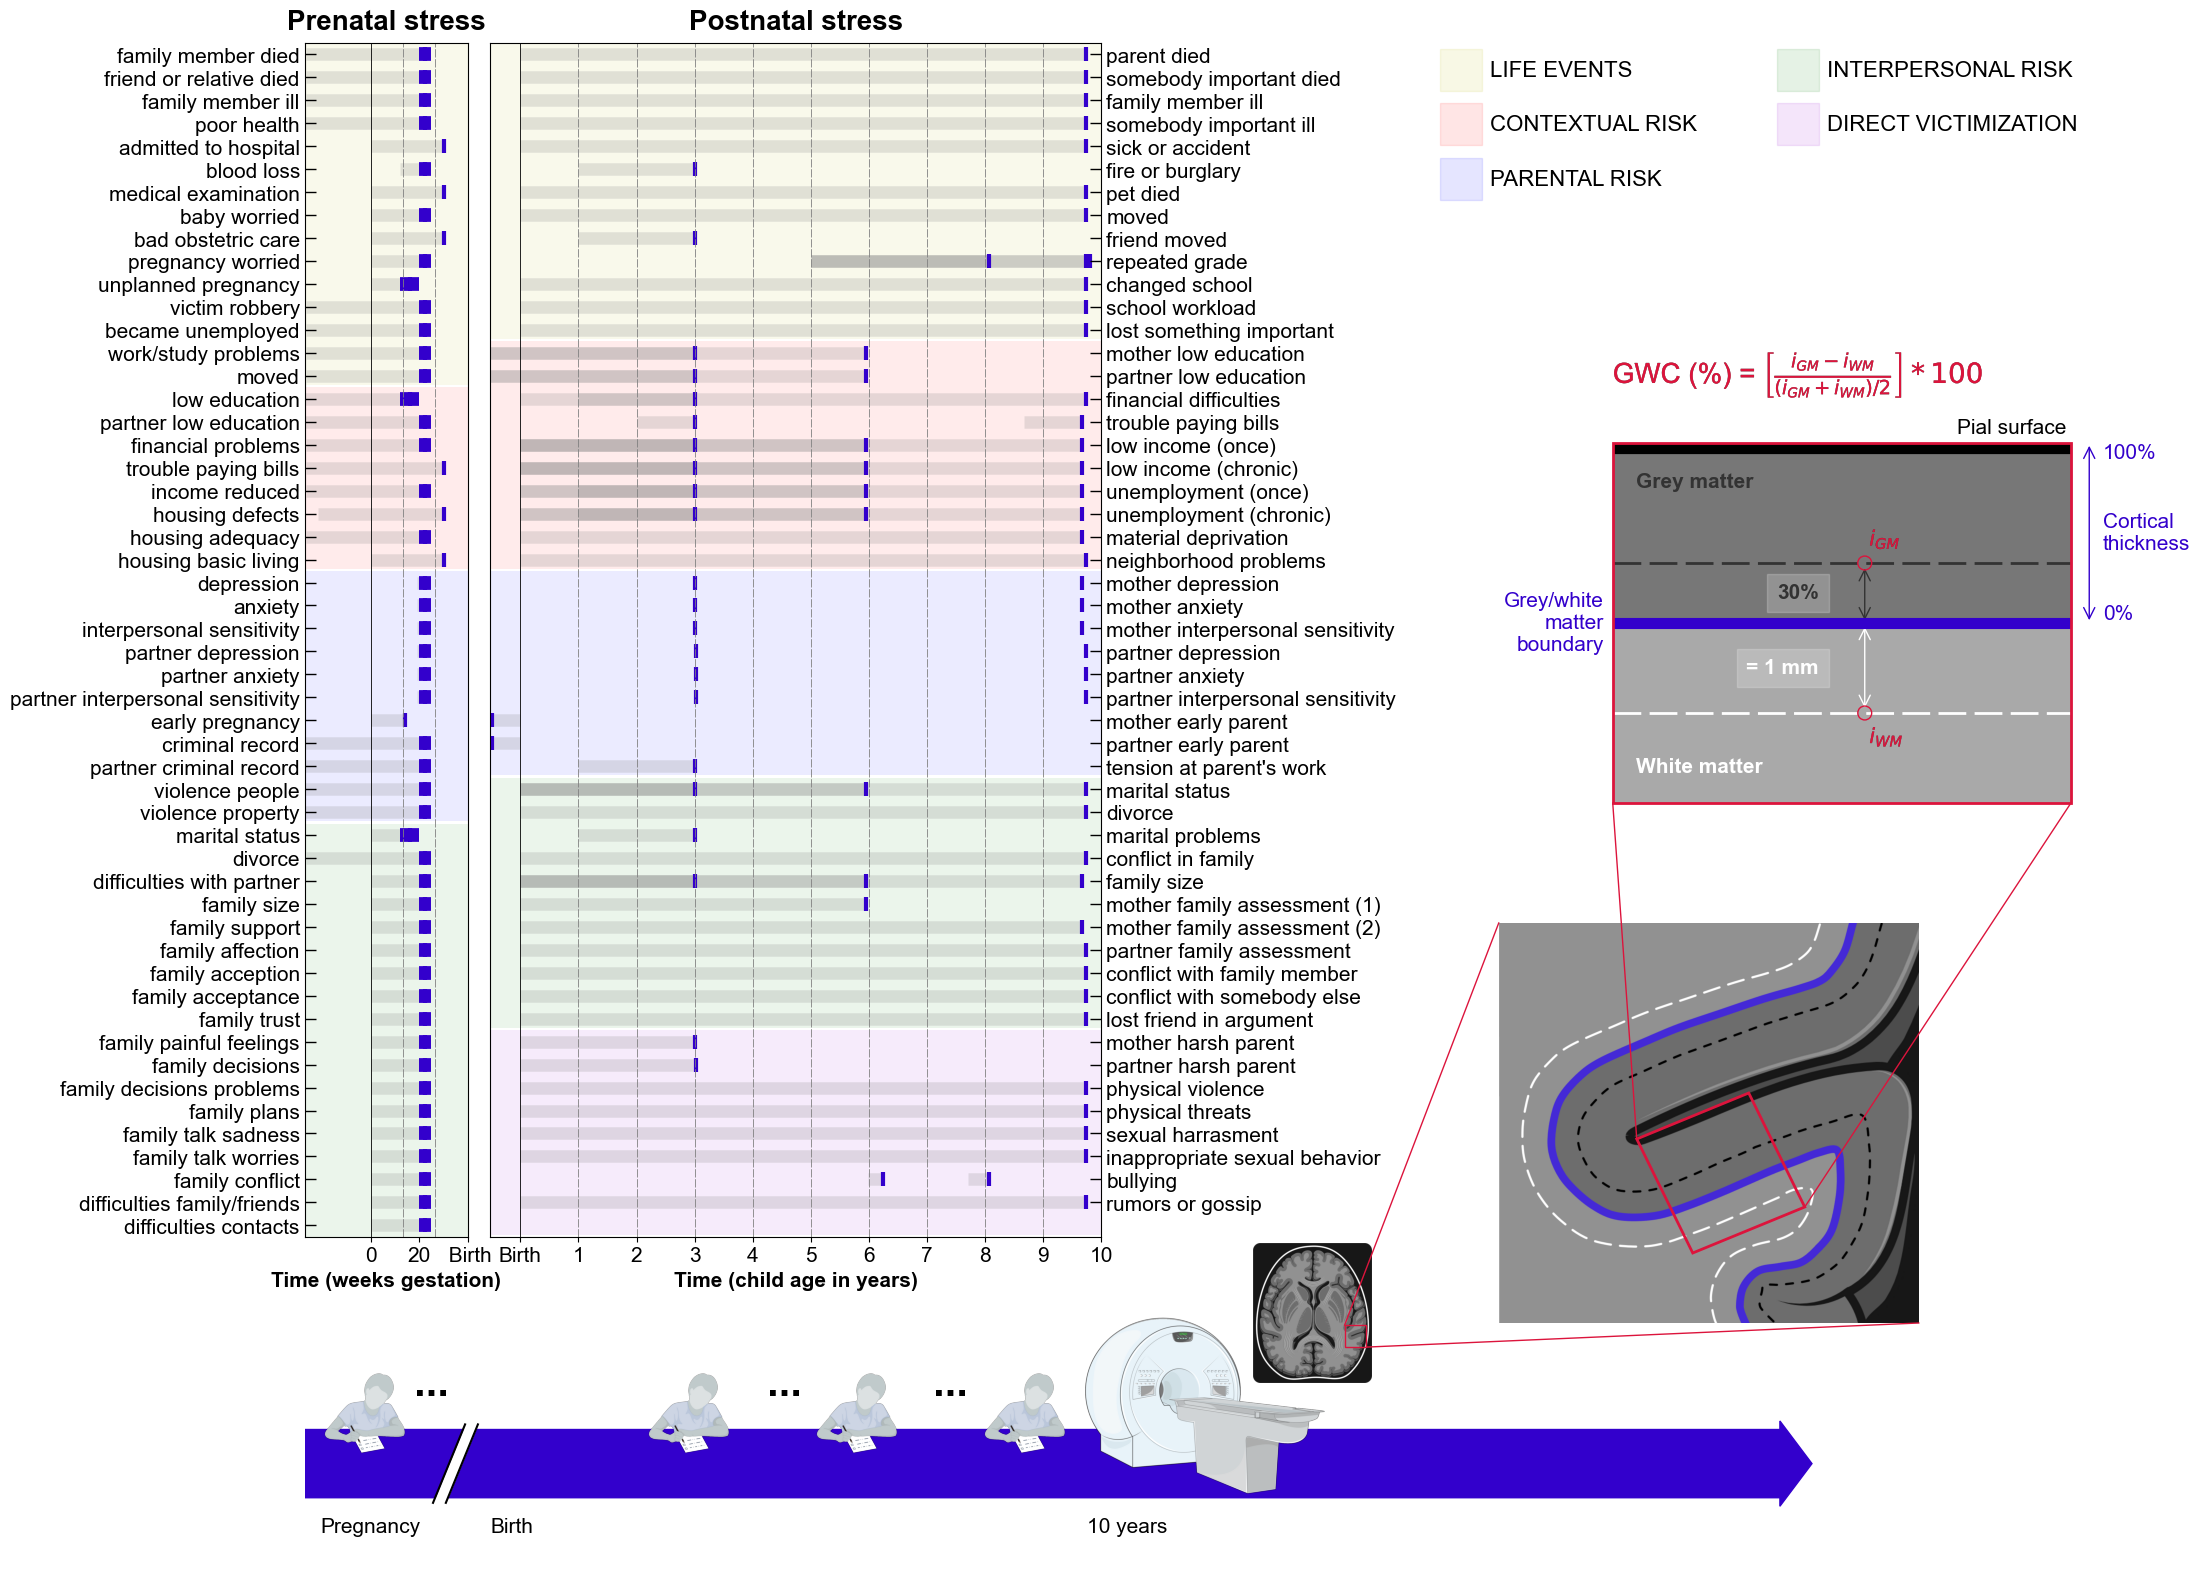

In [5]:
# FIGURE 1
plt.rcParams["font.family"] = "arial"

fig1, axs = plt.subplot_mosaic([['preELS','posELS','.','ELSleg'], 
                                ['timeline','timeline','timeline','timeline']],
                               width_ratios=[4,15,7,18],
                               height_ratios=[10,2],
                               gridspec_kw=dict(wspace=0.05, hspace=0.15),
                               figsize=(24,20))

# ELS PLOT ---------------------------------------------------------------
stress_time(axs['preELS'], t=pre_time, title='Prenatal stress')
stress_time(axs['posELS'], t=pos_time, title='Postnatal stress')

add_legend(axs['ELSleg'])

# TIMELINE ---------------------------------------------------------------
add_timeline(axs['timeline'])

# Questionnaire icons
for qx in [0.13, 0.265, 0.335, 0.405]:
    add_image(fig1, x=qx, y=0.175, size=.04, img_path='../fig1/img1.png')

# MRI machine icon
MRIm_X, MRIm_Y, MRIm_s = .45, .15, .10
add_image(fig1, x=MRIm_X, y=MRIm_Y, size=MRIm_s, img_path='../fig1/img2.png')

# MRI scan icon
scan_X, scan_Y, scan_s = .51, .21, .07
add_image(fig1, x=scan_X, y=scan_Y, size=scan_s, img_path='../fig1/img3.png')

# MRI scan closeup
crop_X, crop_Y, crop_s = .61, .24, .20
add_image(fig1, x=crop_X, y=crop_Y, size=crop_s, img_path='../fig1/img4.png', hcrop=14)

# Scheme
scheme_X, scheme_Y = .67, .50
scheme_w, scheme_h = .21, .18
add_scheme(fig1, position=[scheme_X, scheme_Y, scheme_w, scheme_h])
# Wrap scheme in red
pg = mpl.patches.Polygon([[scheme_X, scheme_Y],[scheme_X, scheme_Y+scheme_h],
                          [scheme_X+scheme_w-(scheme_w/11),scheme_Y+scheme_h],[scheme_X+scheme_w-(scheme_w/11), scheme_Y]], fc='none', ec='crimson', lw=2)
fig1.add_artist(pg)

# zoom polygon: scan to cropped closeup -------------------------------------------------
scan_x1, scan_x2 = scan_X+(scan_s/1.45), scan_X+(scan_s/1.22)
scan_y1, scan_y2 = scan_Y+(scan_s/3.90), scan_Y+(scan_s/2.42)

add_poligon(fig1, p1=[[scan_x1, scan_y2],[scan_x2, scan_y2],[scan_x2, scan_y1],[scan_x1, scan_y1]], 
            p2_top=[crop_X+(crop_s/16), crop_Y+crop_s], 
            p2_bot=(crop_X+crop_s-(crop_s/16), crop_Y))

# zoom polygon: cropped closeup to scheme ----------------------------------------------
cut_xs = np.linspace(crop_X+.07, crop_X+.14, 4)
cut_y1, cut_y2, tilt = crop_Y+.035, crop_Y+.092, .023

add_poligon(fig1, p1=[[cut_xs[0], cut_y2],[cut_xs[2], cut_y2+tilt],[cut_xs[3], cut_y1+tilt],[cut_xs[1], cut_y1]], widths=[2,1],
            p2_top=[scheme_X, scheme_Y], # scheme_Y+scheme_h for upper corner
            p2_bot=[scheme_X+scheme_w-(scheme_w/11), scheme_Y])

# SAVE =================================================================================
fig1.savefig('../Figure1.png', dpi=1000,  bbox_inches='tight')


## Figure 2 and 3

In [4]:
resdir = './src_shiny_app/assets/results/'


def detect_models(resdir=resdir):
    allmods = [x[0].split('/')[-1] for x in os.walk(resdir)][1:]  # assume all stored in resdir

    am_clean = list(set([x.split('.')[1] for x in allmods]))  # assume structure lh.name.measure

    out_terms = {}

    for model in sorted(am_clean):
        # Assume you have left and right hemispheres are always run and with the same model
        mdir = f'{resdir}lh.{model}.w_g.pct'
        stacks = pd.read_table(f'{mdir}/stack_names.txt', delimiter="\t")
        
        out_terms[model] = dict(zip(list(stacks.stack_name)[1:], list(stacks.stack_number)[1:]))
    
    return out_terms

models = detect_models()

In [5]:
def extract_results(model, adj, thr='30'):

    term = f'{model}_z'
    model = f'{model}_{adj}_adjusted'

    stack = models[model][term]

    # Outpout
    min_beta = []
    max_beta = []
    sign_clusters_left_right = {}
    sign_betas_left_right = {}

    for hemi in ['left', 'right']:
        mdir = f'{resdir}{hemi[0]}h.{model}.w_g.pct'
        
        # Read significant cluster map
        ocn = nb.load(f'{mdir}/stack{stack}.cache.th{thr}.abs.sig.ocn.mgh')
        sign_clusters = np.array(ocn.dataobj).flatten()

        if not np.any(sign_clusters):  # all zeros = no significant clusters
            betas = np.empty(sign_clusters.shape)
            betas.fill(np.nan)
        else:
            # Read beta map
            coef = nb.load(f'{mdir}/stack{stack}.coef.mgh')
            betas = np.array(coef.dataobj).flatten()

            # Set non-significant betas to NA
            mask = np.where(sign_clusters == 0)[0]
            betas[mask] = np.nan

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            min_beta.append(np.nanmin(betas))
            max_beta.append(np.nanmax(betas))

        sign_clusters_left_right[hemi] = sign_clusters
        betas[np.isnan(betas)] = 0  # leaving NA causes errors in the color mapping 
        sign_betas_left_right[hemi] = betas 

    return {'min_beta': np.nanmin(min_beta), 'max_beta': np.nanmax(max_beta), 'sign_betas': sign_betas_left_right, 'sign_clusters': sign_clusters_left_right}

def fetch_surface(resolution):
    # Size / number of nodes per map
    n_nodes = {'fsaverage': 163842,
               'fsaverage6': 40962,
               'fsaverage5': 10242}

    return datasets.fetch_surf_fsaverage(mesh=resolution), n_nodes[resolution]

def make_fig(matrix, size=10):
    
    fig, axs = plt.subplot_mosaic(matrix, subplot_kw={'projection': '3d'},
                                  gridspec_kw=dict(wspace=0, hspace=0),
                                  figsize=(size,size))
    return fig, axs

## Figure 2
Th plotting funcitons are not super flexible so I first save individual figures as .png and then I overlay and paste the views together

In [6]:
def plot_surfmap(model, adj='mini',
                 views=['lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior'],
                 surf='infl',  # 'pial', 'infl', 'flat', 'sphere'
                 resol='fsaverage',
                 cmap = 'viridis'):

    # Extract results
    results = {'mini': extract_results(model, adj='mini'), 
               'conf': extract_results(model, adj='conf')}
    
    # Fetch surface base
    fs_avg, n_nodes = fetch_surface(resol)
    
    min_val = np.nanmin([results['mini']['min_beta'], results['conf']['min_beta']])
    max_val = np.nanmax([results['mini']['max_beta'], results['conf']['max_beta']])
    # print(min_val, max_val)

    # if max_val < 0 and min_val < 0:  # all negative associations
    thresh = max_val
    # elif max_val > 0 and min_val > 0:  # all positive associations
    #     thresh = min_val
    # else:
    #     thresh = np.nanmin(abs(stats_map0))

    # Figure structure (save them separetly)
    f1, ax1 = make_fig([['lateral_left','lateral_right'], ['medial_left', 'medial_right']]);
    f2, ax2 = make_fig([['dorsal_left', 'dorsal_right'], ['ventral_right', 'ventral_left']]);
    f3, ax3 = make_fig([['posterior_left', 'posterior_right'], ['anterior_right', 'anterior_left']]);
    
    for hemi in ['left', 'right']:
        
        stats_map = results[adj]['sign_betas'][hemi] # sign_betas
        bg_color = fs_avg[f'sulc_{hemi}'] # if adj=='conf' else None
        
        for view in views:
            
            # Adjust view point (turn dorsal and ventral views)
            if view=='dorsal': 
                coord=(90.0, -90.0)
            elif view=='ventral':
                coord=(-90.0, 90.0)
            else:
                coord=view
            
            # Subplot setting 
            if view in ['lateral', 'medial']:
                fig, axs = f1, ax1 
            elif view in ['dorsal', 'ventral']:
                fig, axs = f2, ax2
            else:
                fig, axs = f3, ax3 

            p = plotting.plot_surf(surf_mesh=fs_avg[f'{surf}_{hemi}'],  # Surface mesh geometry
                                    surf_map=stats_map[:n_nodes],  # Statistical map confounder model
                                    bg_map=bg_color, 
                                    hemi=hemi,
                                    view=coord,
                                    cmap=cmap,
                                    symmetric_cmap=False,
                                    axes= axs[f'{view}_{hemi}'],
                                    figure=fig,
                                    colorbar=False,
                                    vmin=min_val, vmax=max_val,
                                    threshold=abs(thresh))

            xmin, xmax = axs[f'{view}_{hemi}'].get_xlim()  # same left and right
            ymin, ymax = axs[f'{view}_{hemi}'].get_ylim()  # same left and right

            # Remove space between hemispheres
            if view in ['dorsal','ventral','anterior','posterior']:
                shift = 90
                axs[f'{view}_left'].set(xlim=(xmin-shift, xmax-shift))
                axs[f'{view}_right'].set(xlim=(xmin+shift, xmax+shift))
            else:
                shift = 20
                axs[f'lateral_{hemi}'].set(ylim=(ymin+shift, ymax+shift))
                axs[f'medial_{hemi}'].set(ylim=(ymin-shift, ymax-shift))

    
    f1.savefig(f'f1_{model[:4]}_{adj}.png', dpi=1000, bbox_inches='tight');
    f2.savefig(f'f2_{model[:4]}_{adj}.png', dpi=1000, bbox_inches='tight');
    f3.savefig(f'f3_{model[:4]}_{adj}.png', dpi=1000, bbox_inches='tight');
    
    return results[adj]['min_beta'], results[adj]['max_beta']

def add_colorbar(ax, minb0, maxb0, minb1, maxb1):
    
    range0 = maxb0 - minb0 # range of values minimal adjusted
    minp1 = abs(minb1/range0) # proportion of range at min point
    maxp1 = abs(maxb1/range0) # proportion of range at max point
    
    map0 = mpl.colormaps['viridis']
    map1 = mpl.colors.ListedColormap(map0(np.linspace(maxp1, minp1, 128)))

    cb0 = mpl.colorbar.ColorbarBase(ax, cmap=map0, norm=mpl.colors.Normalize(vmin=minb0, vmax=maxb0), alpha=0.25, 
                                    orientation='vertical', ticklocation='right')
    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=map1, norm=mpl.colors.Normalize(vmin=minb1, vmax=maxb1),
                                   orientation='vertical', ticklocation='right')

    ticks = list(np.arange(0, -0.61, -0.05))
    
    cb1.set_label('Beta value', fontsize=12, fontweight='bold', labelpad=15)
    cb1.set_ticks(ticks, labels=['{:.2f}'.format(i) for i in ticks], fontsize=12)


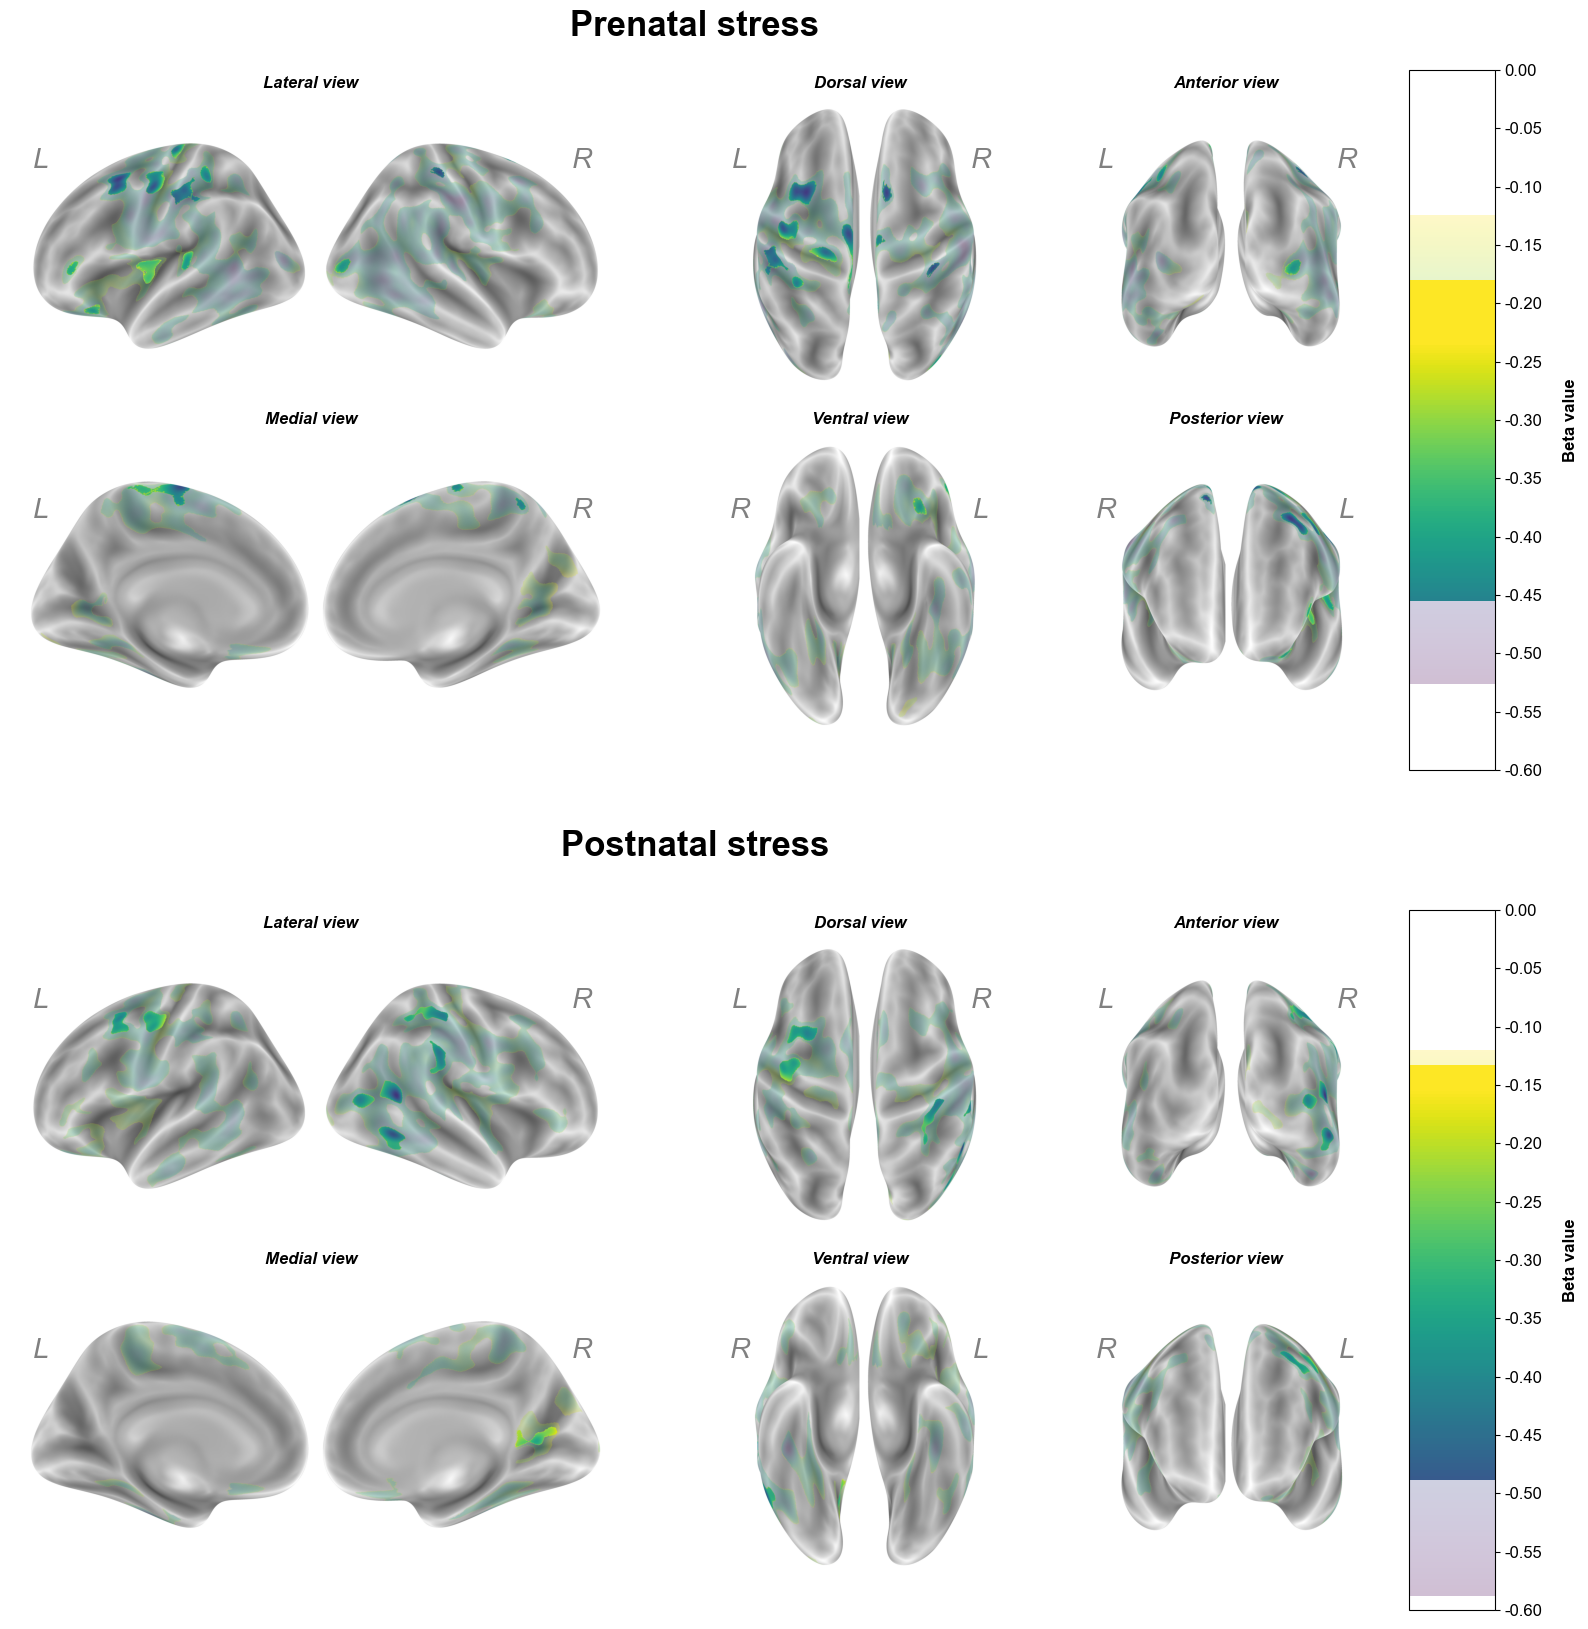

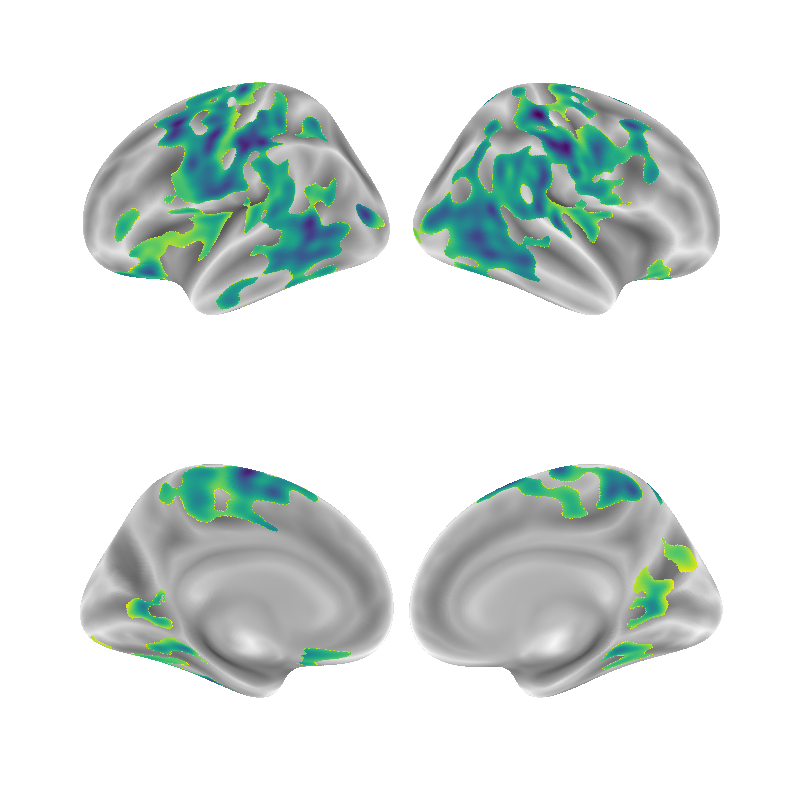

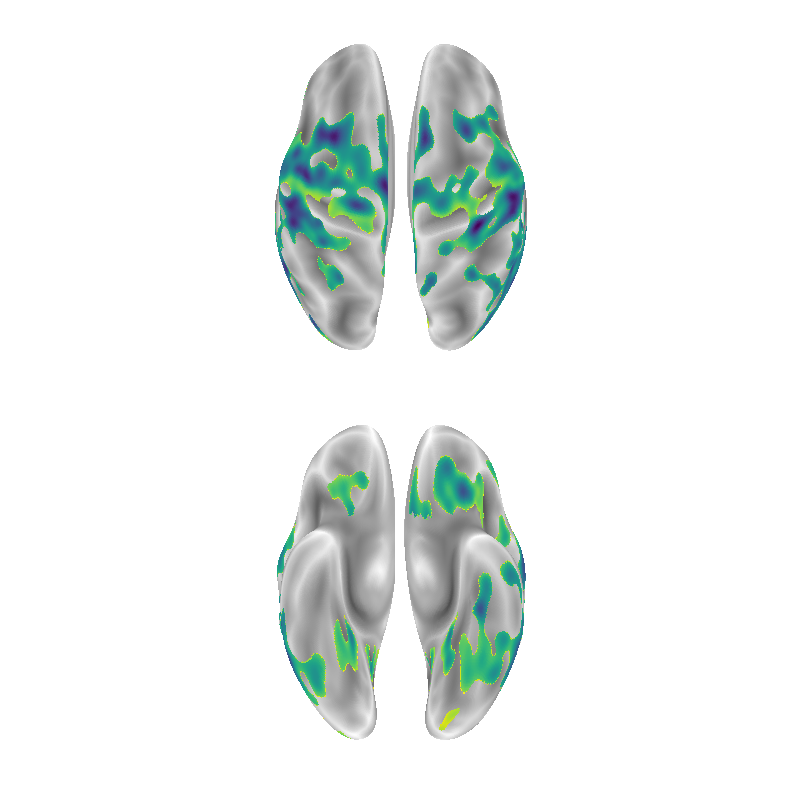

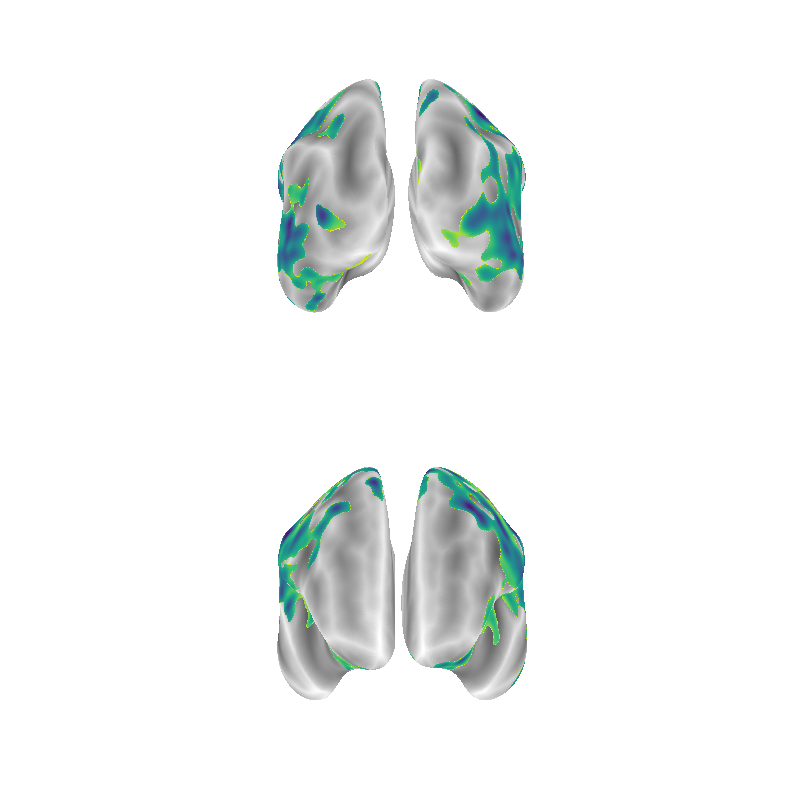

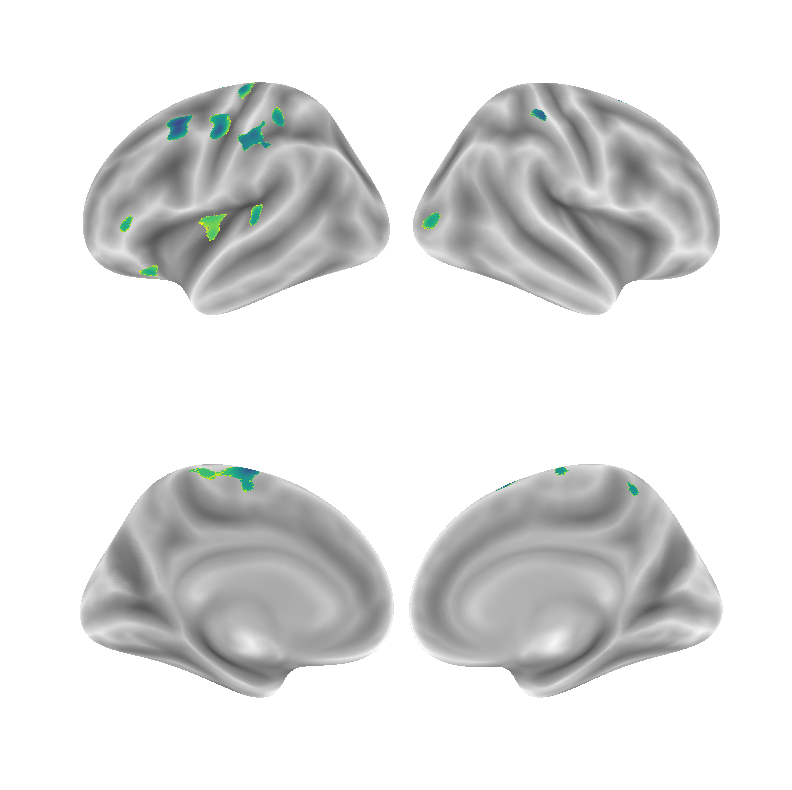

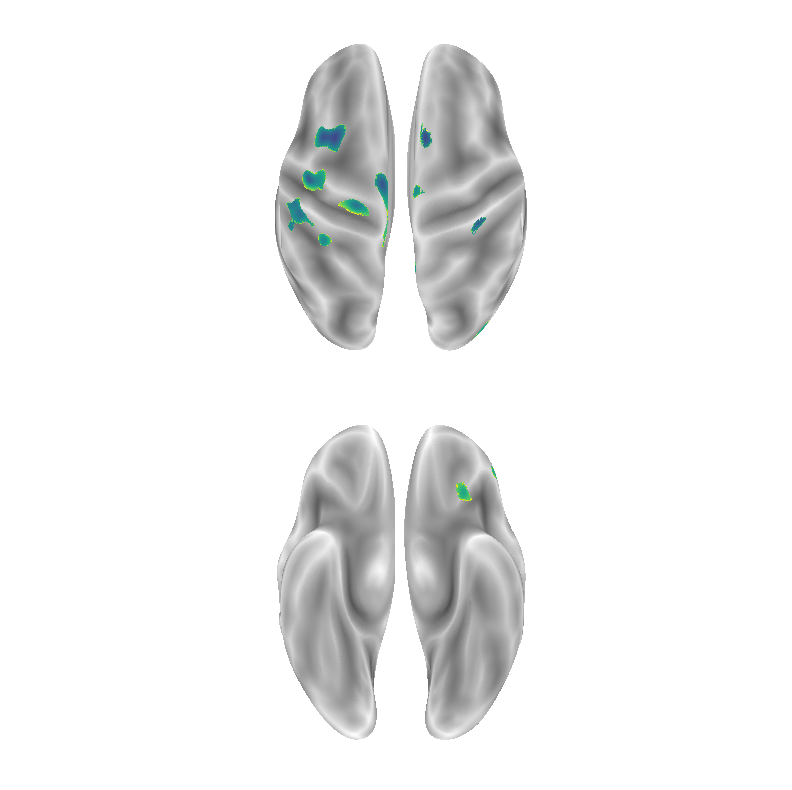

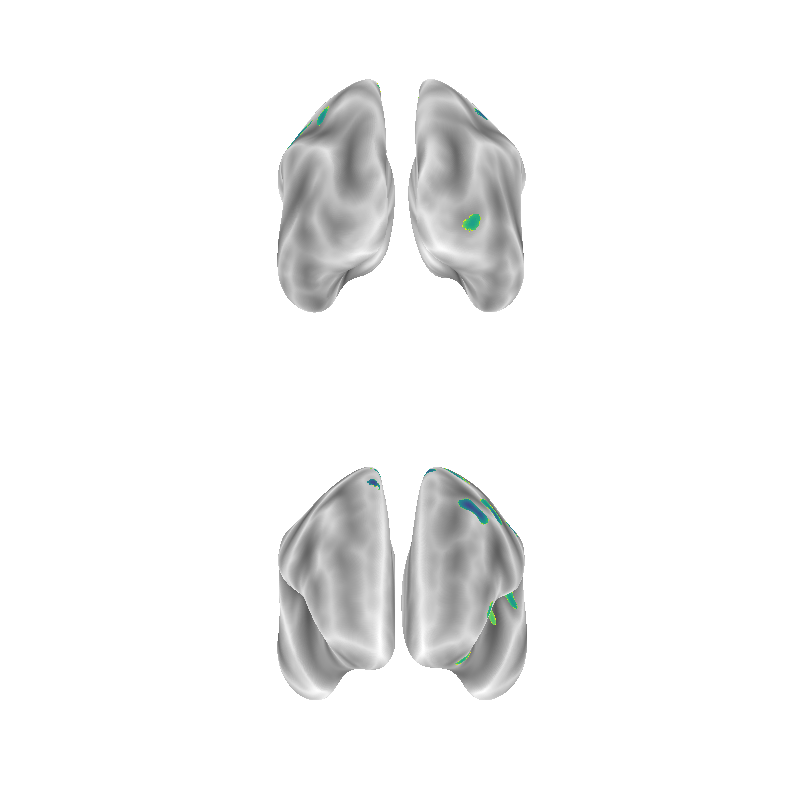

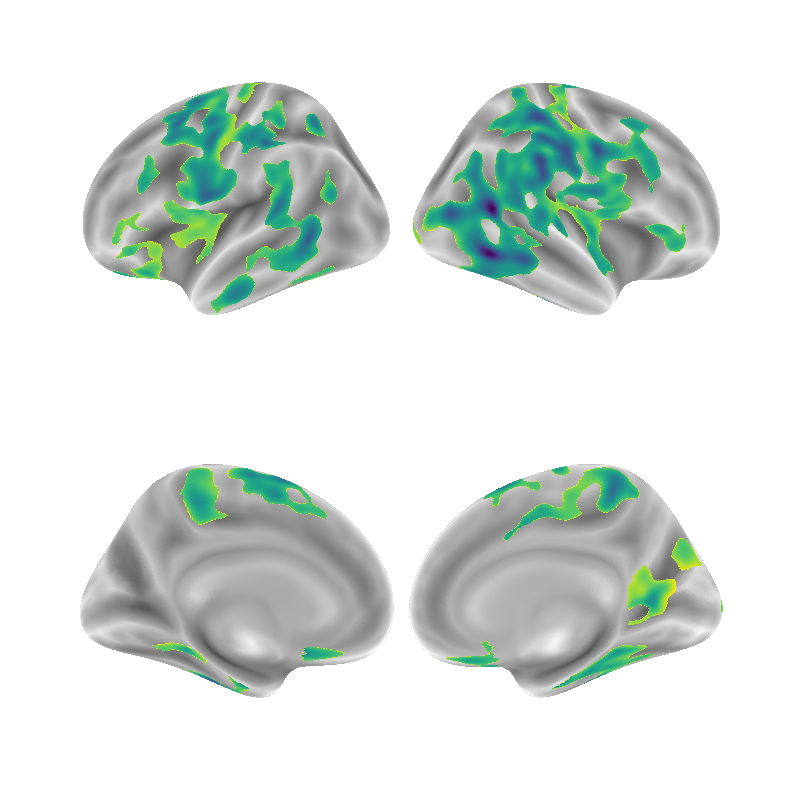

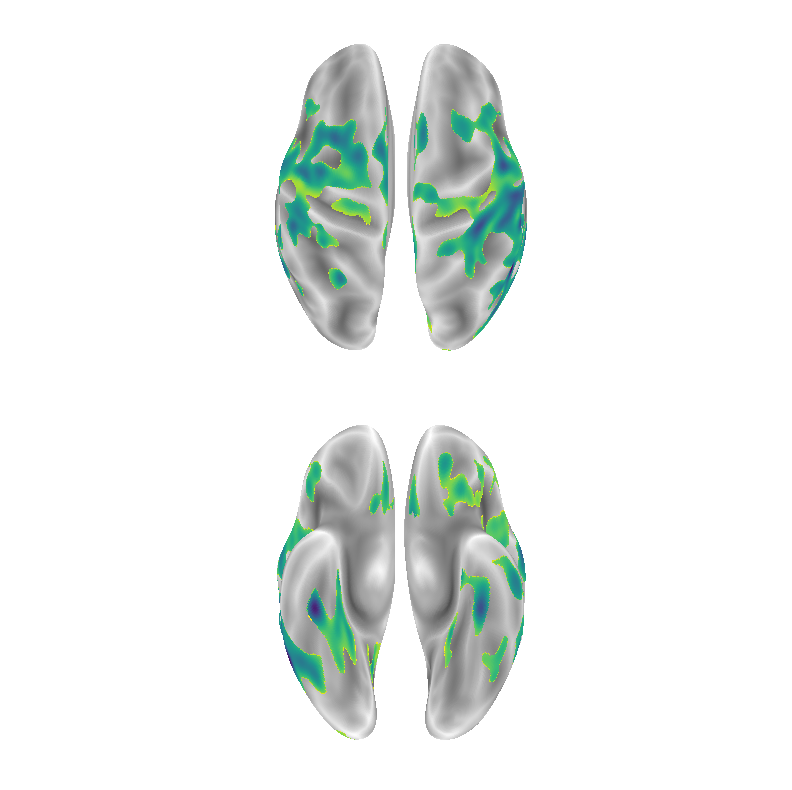

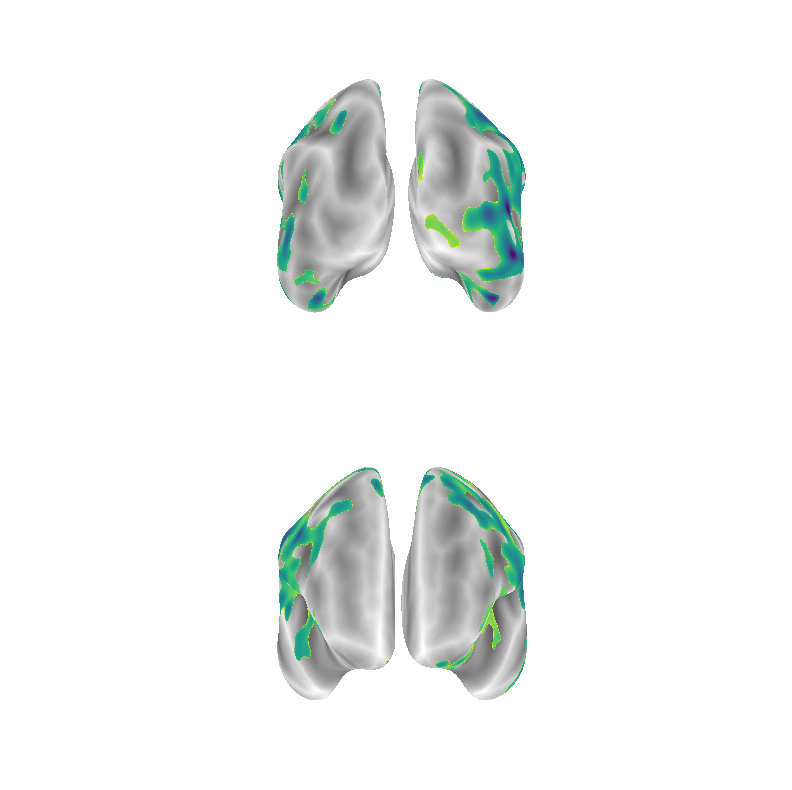

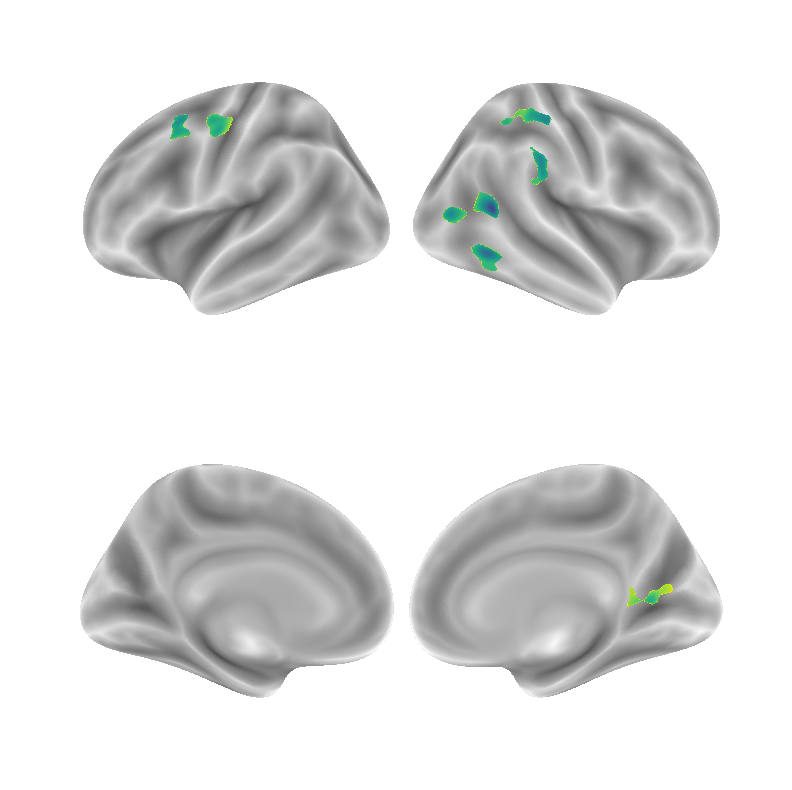

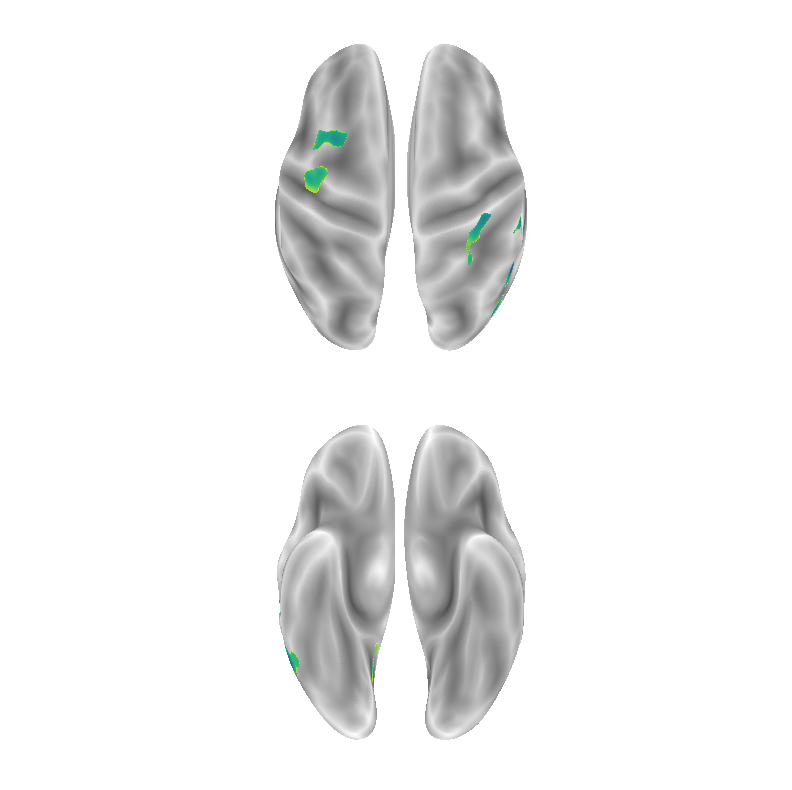

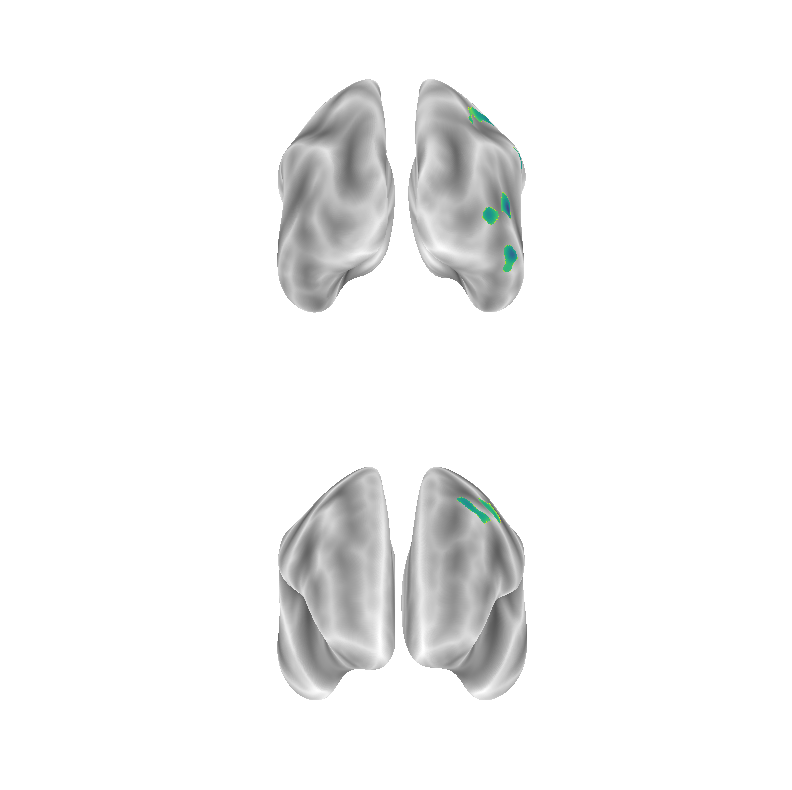

In [9]:
def figure_2(add_minimal=True):
    
    w1 = 6/7; w2 = w3 = 3/7
    h = 1
    
    fig, axs = plt.subplot_mosaic([['f1_pren','f2_pren','f3_pren', 'cbar_pren'],
                                   ['f1_post','f2_post','f3_post', 'cbar_post']],
                              width_ratios=[w1, w2, w3, 1/10], # height_ratios=[h2,h2],
                              gridspec_kw=dict(wspace=0, hspace=0.2),
                              figsize=(20,20))
    
    text = {0: ['Lateral', 'Medial'], 1: ['Dorsal', 'Ventral'], 2: ['Posterior','Anterior']}
    hemi = {0: ['LR', 'LR', .05], 1: ['LR', 'RL', .10], 2: ['LR','RL', .10]}
    
    for model in ['pren','post']:

        m_name = 'prenatal_stress' if model == 'pren' else 'postnatal_stress'
        
        minb0, maxb0 = plot_surfmap(m_name, adj='mini')
        minb1, maxb1 = plot_surfmap(m_name, adj='conf')

        add_colorbar(axs[f'cbar_{model}'], minb0, maxb0, minb1, maxb1)

        for i in range(3):
        
            img_a = image.imread(f'f{i+1}_{model}_conf.png') 
            oh, ow = img_a.shape[0:2]
        
            w = 1-w1 if i==0 else 1-w2
        
            img_a = img_a[int(oh-(oh*h)):int(oh*h), int(ow*(w/2)):int(ow-(ow*(w/2))), :]
        
            axs[f'f{i+1}_{model}'].imshow(img_a)
        
            if add_minimal:
                img_b = image.imread(f'f{i+1}_{model}_mini.png')[int(oh-(oh*h)):int(oh*h), int(ow*(w/2)):int(ow-(ow*(w/2))), :]
                axs[f'f{i+1}_{model}'].imshow(img_b, alpha=0.25)

            # Text 
            
            tstyle = dict(ha='center', va='center', style = 'italic', fontsize = 12, fontweight='bold', transform=axs[f'f{i+1}_{model}'].transAxes)
            axs[f'f{i+1}_{model}'].text(0.5, 0.98, f'{text[i][0]} view', **tstyle)
            axs[f'f{i+1}_{model}'].text(0.5, 0.50, f'{text[i][1]} view', **tstyle)
            
            hstyle = dict(ha='center', va='center', style = 'italic', fontsize = 20, color='grey', transform=axs[f'f{i+1}_{model}'].transAxes)
            x, y1, y2 = hemi[i][2], .87, 0.37
            axs[f'f{i+1}_{model}'].text(x,  y1, f'{hemi[i][0][0]}', **hstyle) 
            axs[f'f{i+1}_{model}'].text(1-x,y1, f'{hemi[i][0][1]}', **hstyle) 
            axs[f'f{i+1}_{model}'].text(x,  y2, f'{hemi[i][1][0]}', **hstyle) 
            axs[f'f{i+1}_{model}'].text(1-x,y2, f'{hemi[i][1][1]}', **hstyle)
    
            axs[f'f{i+1}_{model}'].axis('off')

            # Clean up
            os.remove(f'f{i+1}_{model}_conf.png')
            os.remove(f'f{i+1}_{model}_mini.png')
            
    fig.text(0.5, 0.91, 'Prenatal stress', va='top', ha='center', fontsize=25, fontweight='bold')
    fig.text(0.5, 0.50, 'Postnatal stress',va='top', ha='center', fontsize=25, fontweight='bold')
        
    fig.savefig(f'../Figure2.png', dpi=1000, bbox_inches='tight')
        
figure_2()

## Figure 3

In [13]:
def compute_overlap(model1, model2, adj='conf'):
    
    sign_clusters1 = extract_results(model1, adj=adj)['sign_clusters']
    sign_clusters2 = extract_results(model2, adj=adj)['sign_clusters']

    ovlp_maps = {}
    ovlp_info = {}

    for hemi in ['left', 'right']:
        sign1, sign2 = sign_clusters1[hemi], sign_clusters2[hemi]

        sign1[sign1 > 0] = 1
        sign2[sign2 > 0] = 2

        # Create maps
        ovlp_maps[hemi] = np.sum([sign1, sign2], axis=0)

    #     # Extract info
    #     uniques, counts = np.unique(ovlp_maps[hemi], return_counts=True)
    #     ovlp_info[hemi] = dict(zip(uniques, counts))
    #     ovlp_info[hemi].pop(0)  # only significant clusters

    # # Merge left and right info
    # info = {k: [ovlp_info['left'].get(k, 0) + ovlp_info['right'].get(k, 0)] for k in
    #         set(ovlp_info['left']) | set(ovlp_info['right'])}
    # percent = [round(i[0] / sum(sum(info.values(), [])) * 100, 1) for i in info.values()]

    # for i, k in enumerate(info.keys()):
    #     info[k].append(percent[i])

    return ovlp_maps  #, info

# ----------------------------------------------------------------------------------------

def plot_overlap(model1, model2,
                 views=['lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior'],
                 surf='infl', 
                 resol='fsaverage', 
                 colors=['#634077','#429E9B','#D43545']):  # ['#88CCEE','#DDCC77','#CC6677']
    
    # Figure structure (save them separetly)
    f1, ax1 = make_fig([['lateral_left','lateral_right'], ['medial_left', 'medial_right']]);
    f2, ax2 = make_fig([['dorsal_left', 'dorsal_right'], ['ventral_right', 'ventral_left']]);
    f3, ax3 = make_fig([['posterior_left', 'posterior_right'], ['anterior_right', 'anterior_left']]);

    # Extract results
    ovlp_maps = compute_overlap(model1, model2) #[0]
    fs_avg, n_nodes = fetch_surface(resol)

    cmap = mpl.colors.ListedColormap(colors)

    for hemi in ['left', 'right']:
        
        for view in views:
            
            # Adjust view point (turn dorsal and ventral views)
            if view=='dorsal': 
                coord=(90.0, -90.0)
            elif view=='ventral':
                coord=(-90.0, 90.0)
            else:
                coord=view
            
            # Subplot setting 
            if view in ['lateral', 'medial']:
                fig, axs = f1, ax1 
            elif view in ['dorsal', 'ventral']:
                fig, axs = f2, ax2
            else:
                fig, axs = f3, ax3 

            p = plotting.plot_surf(surf_mesh=fs_avg[f'{surf}_{hemi}'],  # Surface mesh geometry
                                    surf_map=ovlp_maps[hemi][:n_nodes],  # Statistical overlap map
                                    bg_map=fs_avg[f'sulc_{hemi}'],  
                                    hemi=hemi,
                                    view=coord,
                                    cmap=cmap,
                                    symmetric_cmap=False,
                                    axes= axs[f'{view}_{hemi}'],
                                    figure=fig,
                                    colorbar=False,
                                    vmin=1, vmax=3,
                                    threshold=1)

            xmin, xmax = axs[f'{view}_{hemi}'].get_xlim()  # same left and right
            ymin, ymax = axs[f'{view}_{hemi}'].get_ylim()  # same left and right

            # Remove space between hemispheres
            if view in ['dorsal','ventral','anterior','posterior']:
                shift = 90
                axs[f'{view}_left'].set(xlim=(xmin-shift, xmax-shift))
                axs[f'{view}_right'].set(xlim=(xmin+shift, xmax+shift))
            else:
                shift = 20
                axs[f'lateral_{hemi}'].set(ylim=(ymin+shift, ymax+shift))
                axs[f'medial_{hemi}'].set(ylim=(ymin-shift, ymax-shift))

    
    f1.savefig(f'f1_ovlp.png', dpi=1000, bbox_inches='tight');
    f2.savefig(f'f2_ovlp.png', dpi=1000, bbox_inches='tight');
    f3.savefig(f'f3_ovlp.png', dpi=1000, bbox_inches='tight');
    
    return colors


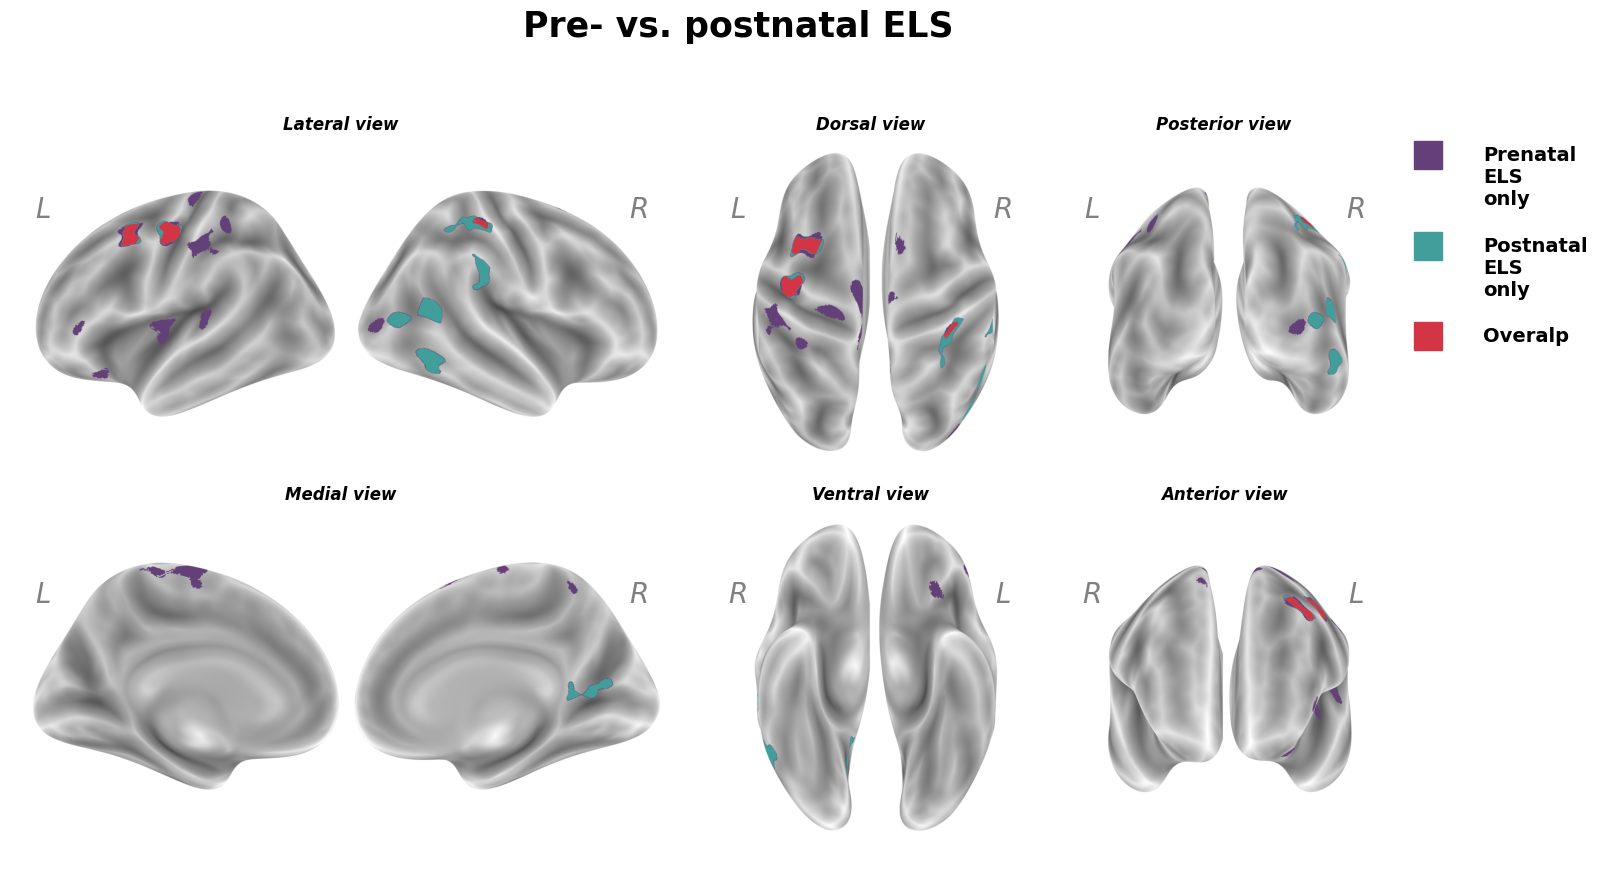

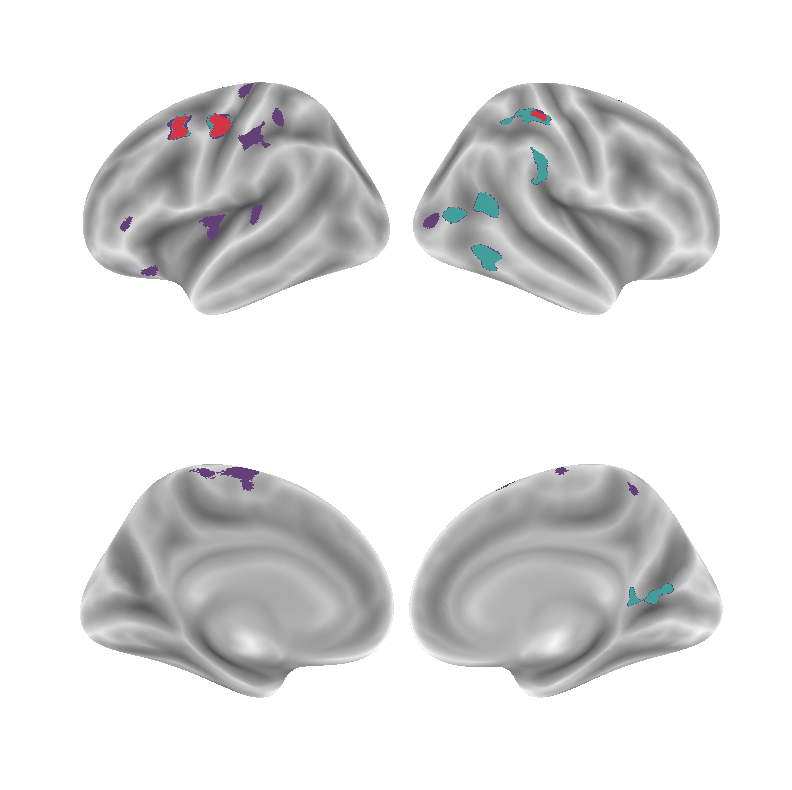

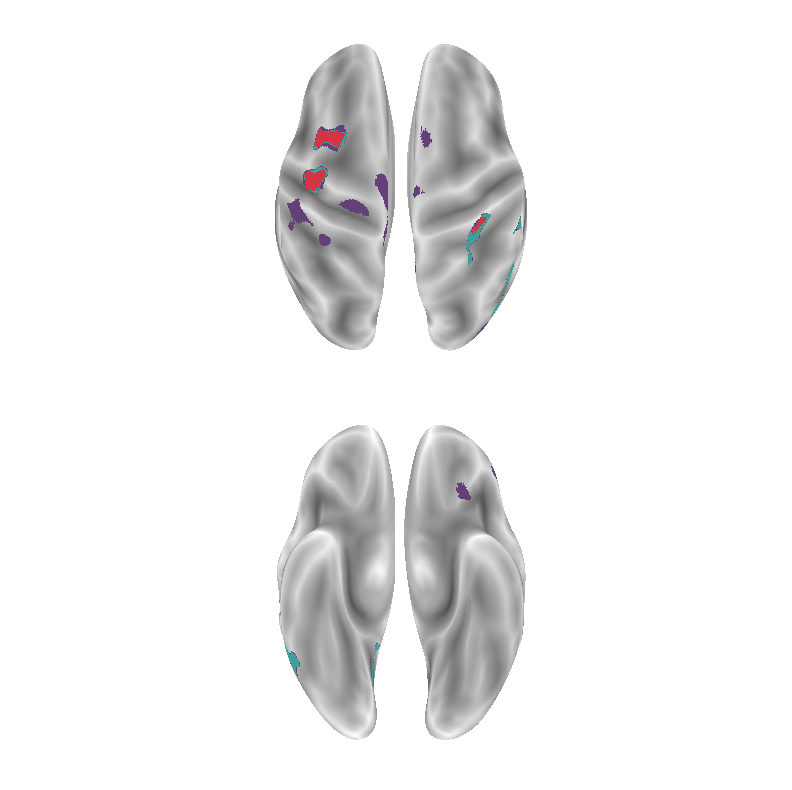

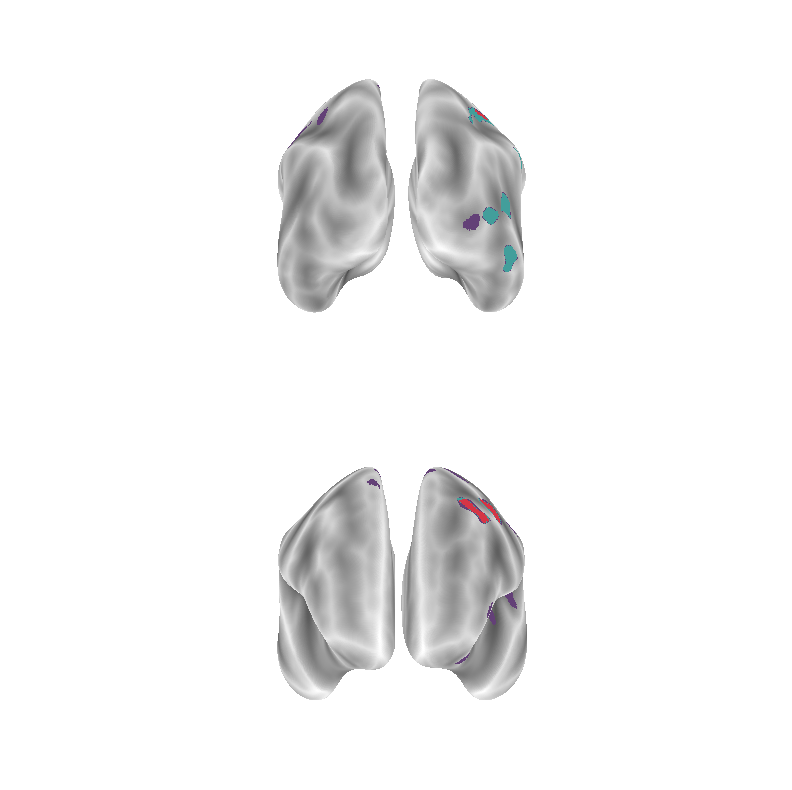

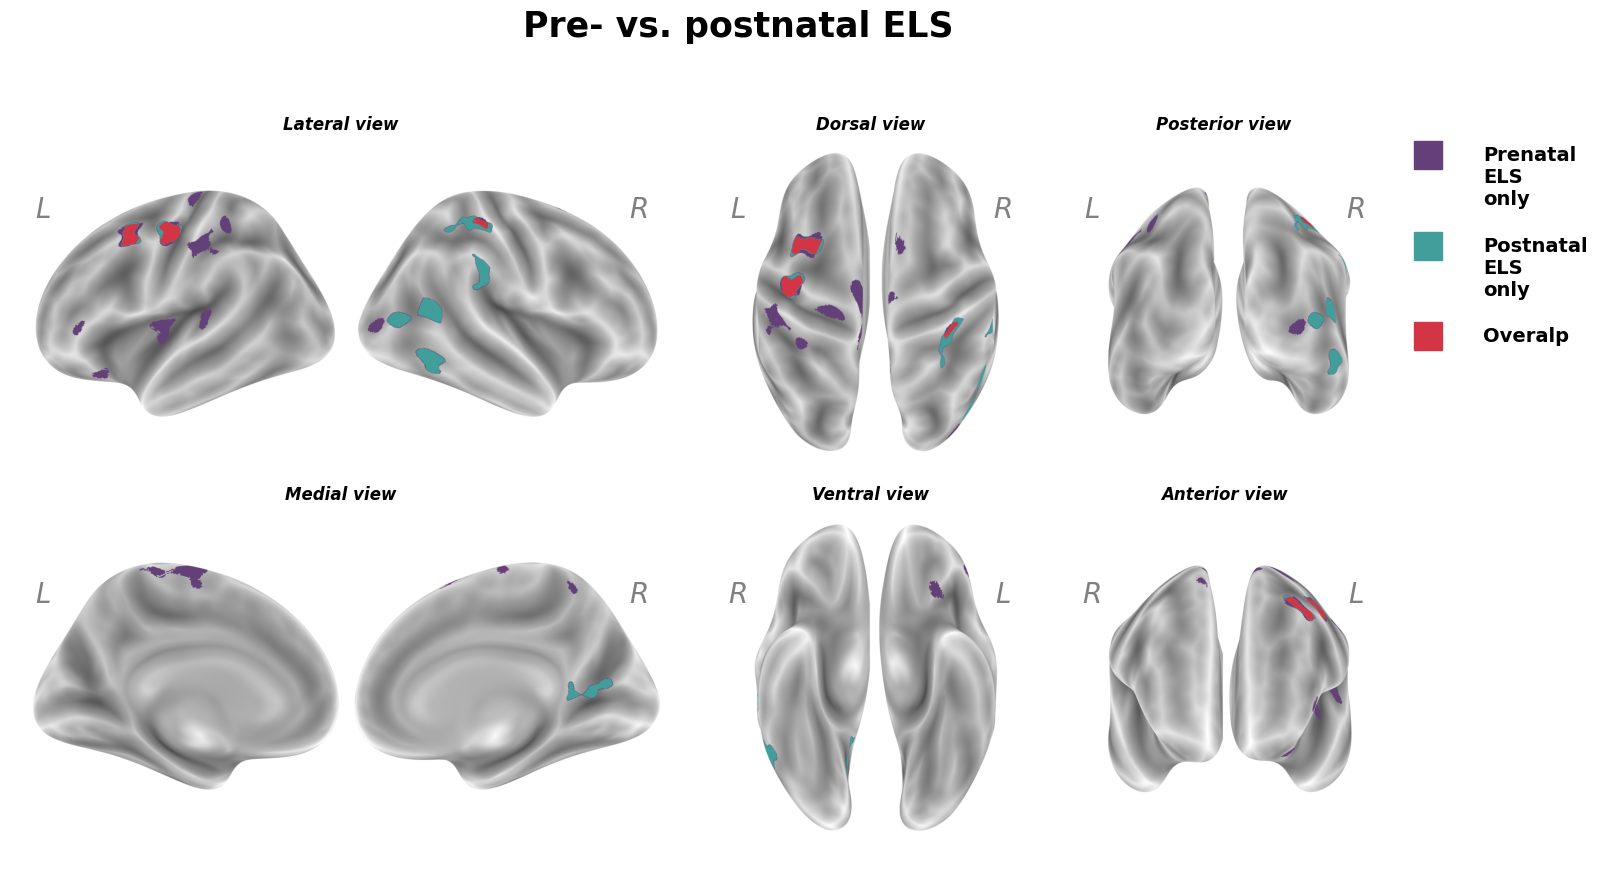

In [14]:
def figure_3(model1, model2, title='Pre- vs. postnatal ELS'):
    
    cols = plot_overlap(model1, model2)

    # Size and structure 
    w1 = 6/7; w2 = w3 = 3/7
    h = 1
    
    fig, axs = plt.subplot_mosaic([['f1','f2','f3', 'leg']],
                                   width_ratios=[w1, w2, w3, 1/6], # height_ratios=[h2,h2],
                                   gridspec_kw=dict(wspace=0, hspace=0),
                                   figsize=(20,10))
    
    text = {0: ['Lateral', 'Medial'], 1: ['Dorsal', 'Ventral'], 2: ['Posterior','Anterior']}
    hemi = {0: ['LR', 'LR', .05], 1: ['LR', 'RL', .10], 2: ['LR','RL', .10]}
    
    for i in range(3):
        img_a = image.imread(f'f{i+1}_ovlp.png') 
        oh, ow = img_a.shape[0:2]
    
        w = 1-w1 if i==0 else 1-w2
    
        img_a = img_a[int(oh-(oh*h)):int(oh*h), int(ow*(w/2)):int(ow-(ow*(w/2))), :]
    
        axs[f'f{i+1}'].imshow(img_a)

        # Text 
        tstyle = dict(ha='center', va='center', style = 'italic', fontsize = 12, fontweight='bold', transform=axs[f'f{i+1}'].transAxes)
        axs[f'f{i+1}'].text(0.5, 0.98, f'{text[i][0]} view', **tstyle)
        axs[f'f{i+1}'].text(0.5, 0.50, f'{text[i][1]} view', **tstyle)
        
        hstyle = dict(ha='center', va='center', style = 'italic', fontsize = 20, color='grey', transform=axs[f'f{i+1}'].transAxes)
        x, y1, y2 = hemi[i][2], .87, 0.37
        axs[f'f{i+1}'].text(x,  y1, f'{hemi[i][0][0]}', **hstyle) 
        axs[f'f{i+1}'].text(1-x,y1, f'{hemi[i][0][1]}', **hstyle) 
        axs[f'f{i+1}'].text(x,  y2, f'{hemi[i][1][0]}', **hstyle) 
        axs[f'f{i+1}'].text(1-x,y2, f'{hemi[i][1][1]}', **hstyle)
    
        axs[f'f{i+1}'].axis('off')

        # Clean up
        os.remove(f'f{i+1}_ovlp.png')

    # Legend
    legend = ['Prenatal\nELS\nonly','Postnatal\nELS\nonly','Overalp']
    for i in range(3):
        axs['leg'].plot(0, i, 's', ms=20, color=cols[i])
        axs['leg'].text(1, i-0.1, legend[i], va='top', fontsize=14, fontweight='bold')
    
    axs['leg'].set(ylim=(-0.5, 8), xlim=(-0.5, 2))
    axs['leg'].invert_yaxis()
    axs['leg'].axis('off')

    # Title
    fig.text(0.5, 0.98, title, va='top', ha='center', fontsize=25, fontweight='bold')
    
    fig.savefig(f'../Figure3.png', dpi=1000, bbox_inches='tight')
    
    return fig

figure_3('prenatal_stress', 'postnatal_stress')

# Other check ups

In [ ]:
## Check regional overlap

h = 'l'
mod = 'postnatal_stress'
df = pd.read_csv(f'{resdir}{h}h.{mod}_conf_adjusted.w_g.pct/significant_clusters.txt', sep='\t')

df.loc[df.variable == f'{mod}_z', ].sort_values(by='n_vertices', ascending=False)

In [ ]:
h = 'r'
mod = 'postnatal_stress'
df = pd.read_csv(f'{resdir}{h}h.{mod}_conf_adjusted.w_g.pct/significant_clusters.txt', sep='\t')

df.loc[df.variable == f'{mod}_z', ].sort_values(by='n_vertices', ascending=False)